## Importing necessary libraries

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torch.nn.functional as F
import cv2
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import imageio
import albumentations as A
import shutil
import json
import numpy as np

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Generating road masks for images

In [2]:
input_dir = '/kaggle/input/segmentation-dataset/IDD_Segmentation/gtFine/train'
output_dir = '/kaggle/working/train_masks'
os.makedirs(output_dir, exist_ok=True)

def create_mask_from_polygon(img_width, img_height, objects):
    mask = np.zeros((img_height, img_width), dtype=np.uint8)  
    for obj in objects:
        polygon = np.array(obj["polygon"], dtype=np.int32)  
        if obj['label'] == 'road': # only extracting road masks from all given labels
            cv2.fillPoly(mask, [polygon], 255)
        else:
            cv2.fillPoly(mask, [polygon], 0)
    return mask
for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        output_folder = os.path.join(output_dir, folder)
        os.makedirs(output_folder, exist_ok=True)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                json_path = os.path.join(folder_path, file_name)
                with open(json_path, 'r') as json_file:
                    data = json.load(json_file)
                    
                    img_width = data["imgWidth"]
                    img_height = data["imgHeight"]
                    
                    mask = create_mask_from_polygon(img_width, img_height, data["objects"])
                    output_mask_path = os.path.join(output_folder, file_name.replace('.json', '_mask.png'))
                    
                    cv2.imwrite(output_mask_path, mask)


In [3]:
input_dir = '/kaggle/input/segmentation-dataset/IDD_Segmentation/gtFine/val'
output_dir = '/kaggle/working/val_masks'
os.makedirs(output_dir, exist_ok=True)

def create_mask_from_polygon(img_width, img_height, objects):
    mask = np.zeros((img_height, img_width), dtype=np.uint8)  
    for obj in objects:
        polygon = np.array(obj["polygon"], dtype=np.int32)  
        if obj['label'] == 'road': #only extracting road masks from all given labels
            cv2.fillPoly(mask, [polygon], 255)
        else:
            cv2.fillPoly(mask, [polygon], 0)
    return mask
for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        output_folder = os.path.join(output_dir, folder)
        os.makedirs(output_folder, exist_ok=True)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                json_path = os.path.join(folder_path, file_name)
                with open(json_path, 'r') as json_file:
                    data = json.load(json_file)
                    
                    img_width = data["imgWidth"]
                    img_height = data["imgHeight"]
                    
                    mask = create_mask_from_polygon(img_width, img_height, data["objects"])
                    output_mask_path = os.path.join(output_folder, file_name.replace('.json', '_mask.png'))
                    
                    cv2.imwrite(output_mask_path, mask)


## Dataset Class

In [4]:
class RoadSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.image_paths = []
        self.mask_paths = []
        for folder in os.listdir(img_dir):
            folder_path = os.path.join(img_dir, folder)
            if os.path.isdir(folder_path):
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.png'):
                        img_path = os.path.join(folder_path, file_name)
                        self.image_paths.append(img_path)
                        mask_filename = file_name.replace('_leftImg8bit.png', '_gtFine_polygons_mask.png')
                        mask_folder = os.path.basename(folder_path)
                        mask_path = os.path.join(mask_dir, mask_folder, mask_filename)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx],cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 0).astype(np.uint8)
        
        aug=self.transforms(image=img,mask=mask)
        img=Image.fromarray(aug['image'])
        mask=aug['mask']
        
        t=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #Normalizing using standard Imagenet mean and deviation
        img=t(img)
        mask=torch.from_numpy(mask).float()
        
        return img, mask

In [5]:
train_img_dir='/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/train'
train_mask_dir='/kaggle/working/train_masks'
val_img_dir='/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/val'
val_mask_dir='/kaggle/working/val_masks'

In [6]:
#Train transformtions consist only of flips, distortions and color changes, since conversion to 
#tensor and normalization have already been done while creating the dataset class

train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.4),
    A.RGBShift(p=0.3),
    A.ToGray(p=0.1)
])


#validation dataset consists only of resizing, no augmentations

val_transforms=A.Compose([
    A.Resize(224,224)
])

In [7]:
train_dataset = RoadSegDataset(train_img_dir, train_mask_dir, transforms=train_transforms)
val_dataset = RoadSegDataset(val_img_dir, val_mask_dir, transforms=val_transforms)

In [8]:
train_dl=DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4)
val_dl=DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=4)

## A Function to Visualise images and their respective masks

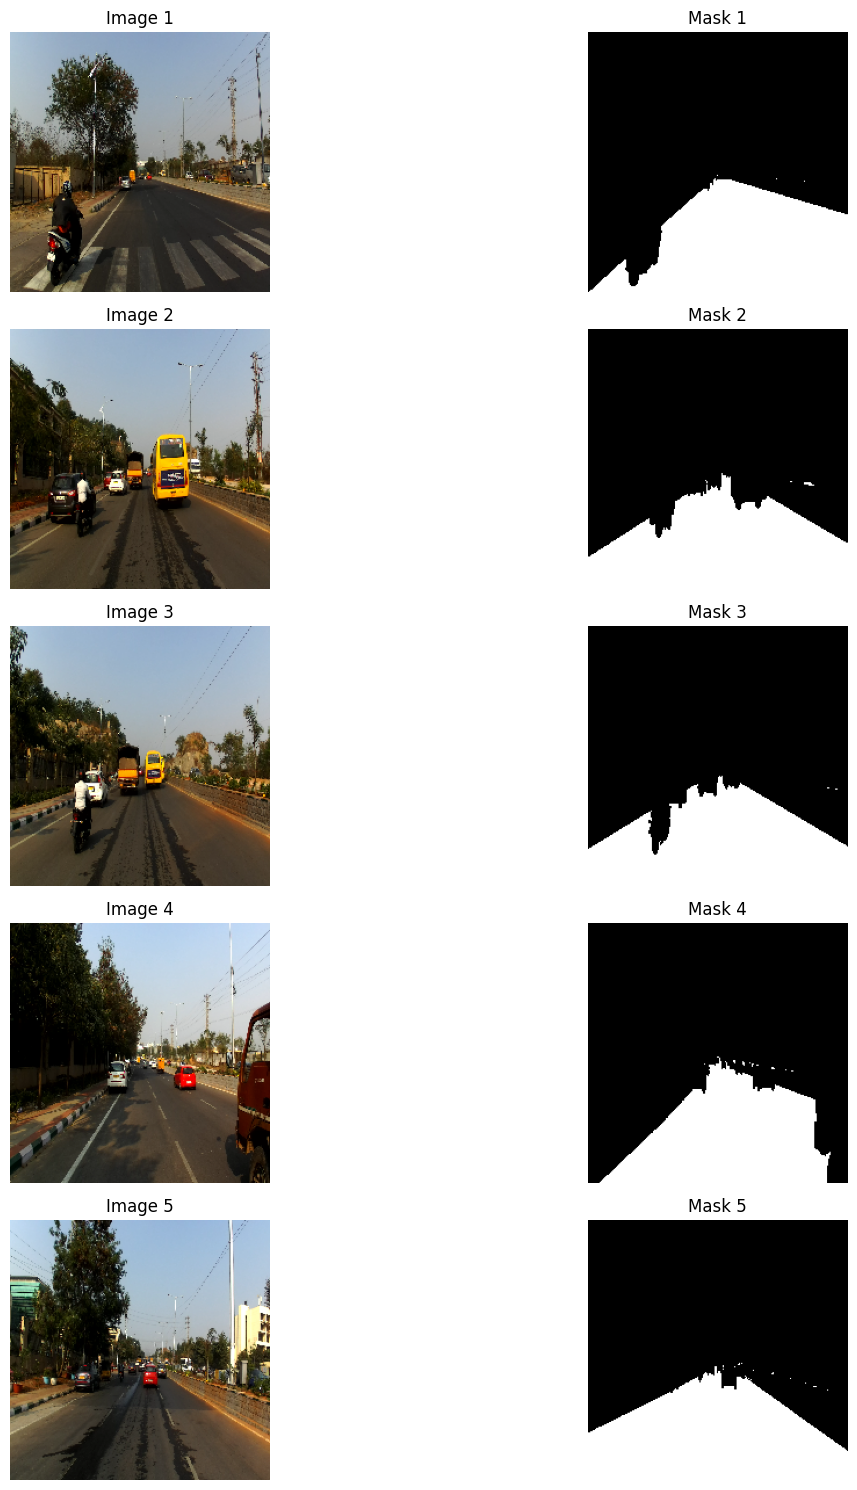

In [9]:
def visualize_images_and_masks(dataloader, num_samples=5):
    for images, masks in dataloader:
        plt.figure(figsize=(15, num_samples * 3))
        
        for i in range(num_samples):
            img = images[i].permute(1, 2, 0).numpy()  
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 
            img = np.clip(img, 0, 1)
            mask = masks[i].numpy()
            
            plt.subplot(num_samples, 2, 2*i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Image {i + 1}')
            
            plt.subplot(num_samples, 2, 2*i + 2)
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.title(f'Mask {i + 1}')
        
        plt.tight_layout()
        plt.show()
        break  

visualize_images_and_masks(val_dl, num_samples=5)

# 1. Vanilla UNet

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
class Block(nn.Module):
    def __init__(self, inChannels, outChannels, kernel_size=3):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size, padding=padding)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(Encoder, self).__init__()
        self.block = Block(inChannels, outChannels, 3)
        self.down_sample = nn.MaxPool2d(2)
        
    def forward(self, x):
        skipOut = self.block(x)
        downOut = self.down_sample(skipOut)
        return skipOut, downOut

class Decoder(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(Decoder, self).__init__()
        self.up_sample = nn.ConvTranspose2d(inChannels, outChannels, kernel_size=2, stride=2)
        self.block = Block(inChannels, outChannels)
        
    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        x = self.block(x)
        return x

class Unet(nn.Module):
    def __init__(self, out_classes=1):
        super(Unet, self).__init__()
        self.encoder1 = Encoder(3, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)
        self.encoder4 = Encoder(256, 512)
        self.middle = Block(512, 1024)
        self.decoder4 = Decoder(1024, 512)
        self.decoder3 = Decoder(512, 256)
        self.decoder2 = Decoder(256, 128)
        self.decoder1 = Decoder(128, 64)
        self.out_conv = nn.Conv2d(64, out_classes, kernel_size=1)
        
    def forward(self, x):
        skip1, x = self.encoder1(x)  # 64 channels
        skip2, x = self.encoder2(x)  # 128 channels
        skip3, x = self.encoder3(x)  # 256 channels
        skip4, x = self.encoder4(x)  # 512 channels
        x = self.middle(x)            # 1024 channels
        x = self.decoder4(x, skip4)   # 512 channels
        x = self.decoder3(x, skip3)   # 256 channels
        x = self.decoder2(x, skip2)   # 128 channels
        x = self.decoder1(x, skip1)   # 64 channels
        x = self.out_conv(x)          # out_classes channels
        return x

vanilla_unet=Unet()
vanilla_unet.to(device)

Unet(
  (encoder1): Encoder(
    (block): Block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Encoder(
    (block): Block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): Encoder(
    (block): Block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [12]:
# Training parameters

batch_size=32
num_epochs=10
learning_rate=1e-3
decay=1e-4

In [13]:
def iou_metric(preds, targets, smooth=1e-6):
    preds = preds.sigmoid()  
    preds = (preds > 0.5).float()  
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

In [14]:
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.sigmoid()
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    dice = (2 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

In [15]:
# Training loop

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vanilla_unet.parameters(), lr=learning_rate, weight_decay=decay)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    vanilla_unet.train()
    train_loss = 0.0
    train_iou = 0.0
    train_dice = 0.0
    for images, masks in tqdm(train_dl):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()  
        outputs = vanilla_unet(images)
        
        loss = criterion(outputs, masks.unsqueeze(1))  
        loss.backward()  
        optimizer.step()  
        
        train_loss += loss.item()
        train_iou += iou_metric(outputs, masks)
        train_dice += dice_score(outputs, masks)

    avg_train_loss = train_loss / len(train_dl)
    avg_train_iou = train_iou / len(train_dl)
    avg_train_dice = train_dice / len(train_dl)

    train_losses.append(avg_train_loss)

    vanilla_unet.eval()  
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0
    
    with torch.no_grad():  
        for val_images, val_masks in val_dl:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            
            val_outputs = vanilla_unet(val_images)
            
            val_loss_value = criterion(val_outputs, val_masks.unsqueeze(1).float())
            val_loss += val_loss_value.item()
            val_iou += iou_metric(val_outputs, val_masks)
            val_dice += dice_score(val_outputs, val_masks)

    avg_val_loss = val_loss / len(val_dl)
    avg_val_iou = val_iou / len(val_dl)
    avg_val_dice = val_dice / len(val_dl)

    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
      f"Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Train DICE: {avg_train_dice:.4f}, "
      f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val DICE: {avg_val_dice:.4f}")

100%|██████████| 219/219 [04:10<00:00,  1.14s/it]


Epoch [1/10], Train Loss: 0.4010, Train IoU: 0.3908, Train DICE: 0.5279, Val Loss: 0.2942, Val IoU: 0.6010, Val DICE: 0.7403


100%|██████████| 219/219 [04:09<00:00,  1.14s/it]


Epoch [2/10], Train Loss: 0.3277, Train IoU: 0.5597, Train DICE: 0.7162, Val Loss: 0.2811, Val IoU: 0.5647, Val DICE: 0.7065


100%|██████████| 219/219 [04:08<00:00,  1.13s/it]


Epoch [3/10], Train Loss: 0.2984, Train IoU: 0.5979, Train DICE: 0.7471, Val Loss: 0.1958, Val IoU: 0.7509, Val DICE: 0.8520


100%|██████████| 219/219 [04:07<00:00,  1.13s/it]


Epoch [4/10], Train Loss: 0.2869, Train IoU: 0.6152, Train DICE: 0.7605, Val Loss: 0.1891, Val IoU: 0.7472, Val DICE: 0.8494


100%|██████████| 219/219 [04:06<00:00,  1.13s/it]


Epoch [5/10], Train Loss: 0.2713, Train IoU: 0.6336, Train DICE: 0.7748, Val Loss: 0.2148, Val IoU: 0.6952, Val DICE: 0.8118


100%|██████████| 219/219 [04:06<00:00,  1.12s/it]


Epoch [6/10], Train Loss: 0.2647, Train IoU: 0.6424, Train DICE: 0.7812, Val Loss: 0.2020, Val IoU: 0.7282, Val DICE: 0.8345


100%|██████████| 219/219 [04:06<00:00,  1.12s/it]


Epoch [7/10], Train Loss: 0.2568, Train IoU: 0.6553, Train DICE: 0.7907, Val Loss: 0.1900, Val IoU: 0.7327, Val DICE: 0.8369


100%|██████████| 219/219 [04:04<00:00,  1.12s/it]


Epoch [8/10], Train Loss: 0.2559, Train IoU: 0.6559, Train DICE: 0.7912, Val Loss: 0.1898, Val IoU: 0.7373, Val DICE: 0.8401


100%|██████████| 219/219 [04:03<00:00,  1.11s/it]


Epoch [9/10], Train Loss: 0.2498, Train IoU: 0.6638, Train DICE: 0.7970, Val Loss: 0.1732, Val IoU: 0.7638, Val DICE: 0.8609


100%|██████████| 219/219 [04:03<00:00,  1.11s/it]


Epoch [10/10], Train Loss: 0.2429, Train IoU: 0.6719, Train DICE: 0.8028, Val Loss: 0.1858, Val IoU: 0.7404, Val DICE: 0.8424


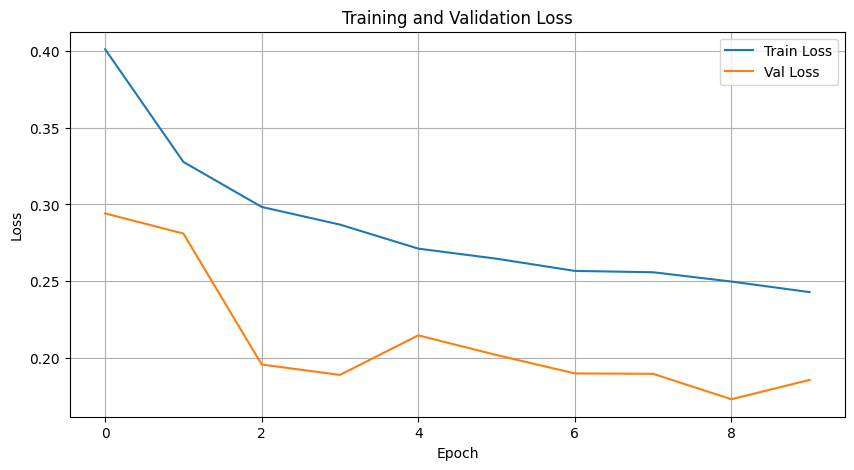

In [16]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def test_model(model, img_paths, device, img_transforms=None):
    model.eval()  
    predictions = []
    
    with torch.no_grad():
        for img_path in img_paths:
            # Load and preprocess the image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img_transforms:
                augmented = img_transforms(image=img)
                img = augmented['image']
            img = Image.fromarray(img)
            preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
            img = preprocess(img)
            img = img.unsqueeze(0).to(device)  

            # Make prediction
            output = model(img)
            pred = torch.sigmoid(output)  
            pred = (pred > 0.5).float()  
            predictions.append(pred.cpu().numpy()[0])  
            
    return predictions


def visualize_predictions(img_paths, predictions):
    for img_path, pred in zip(img_paths, predictions):
        img = cv2.imread(img_path)
        img=cv2.resize(img,(512,512))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = pred[0]  
        mask = (mask * 255).astype(np.uint8)  

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()

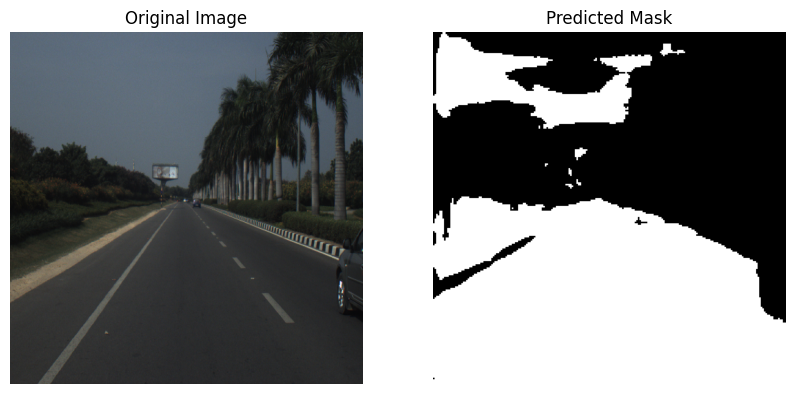

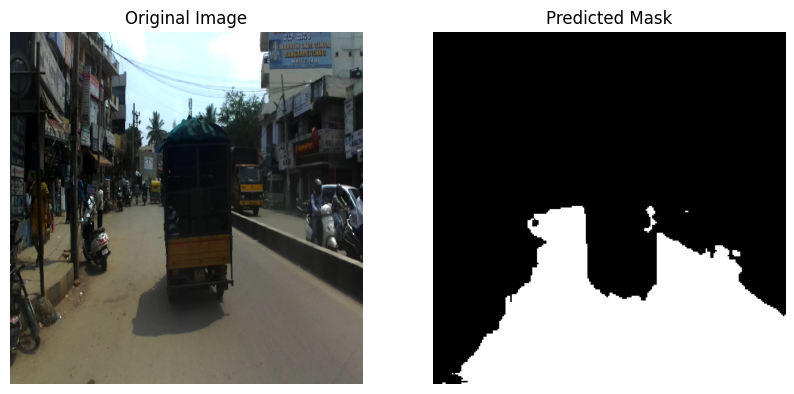

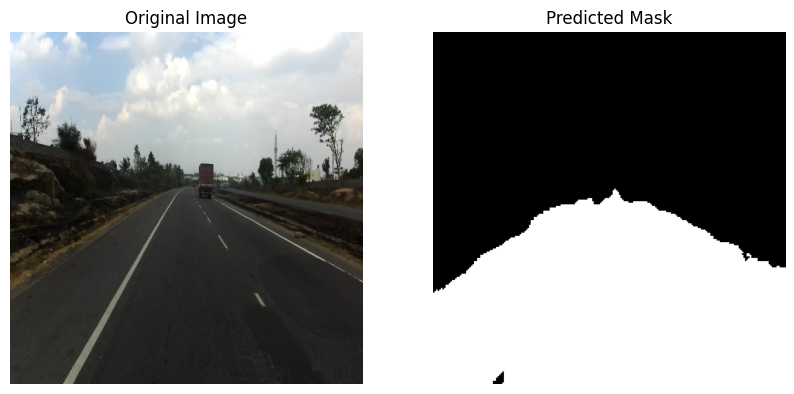

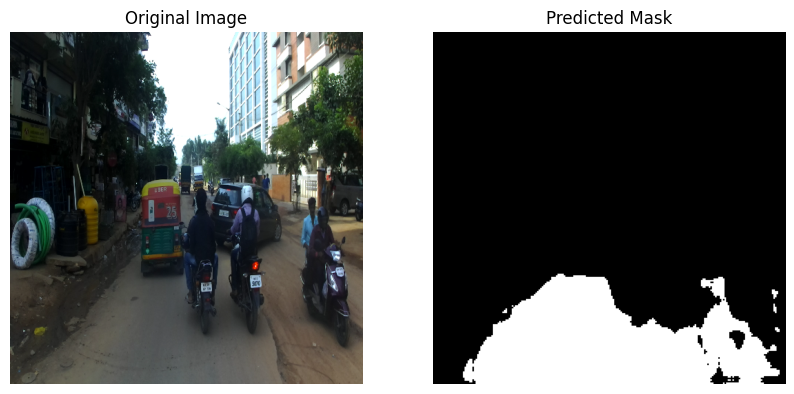

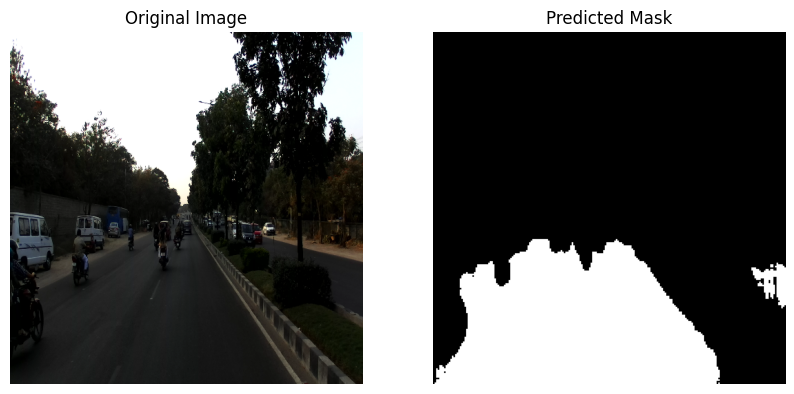

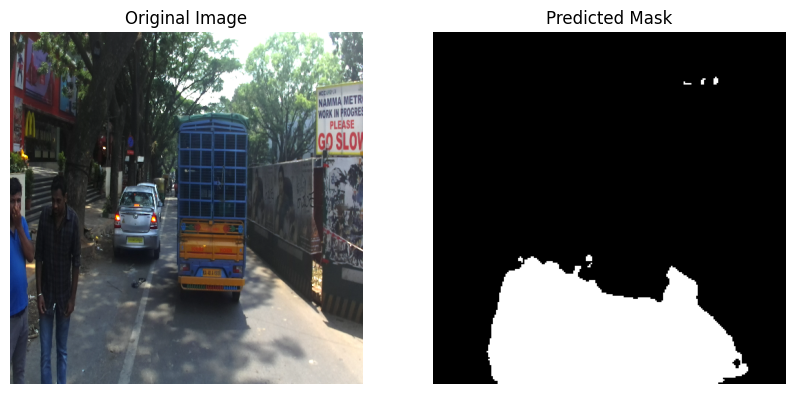

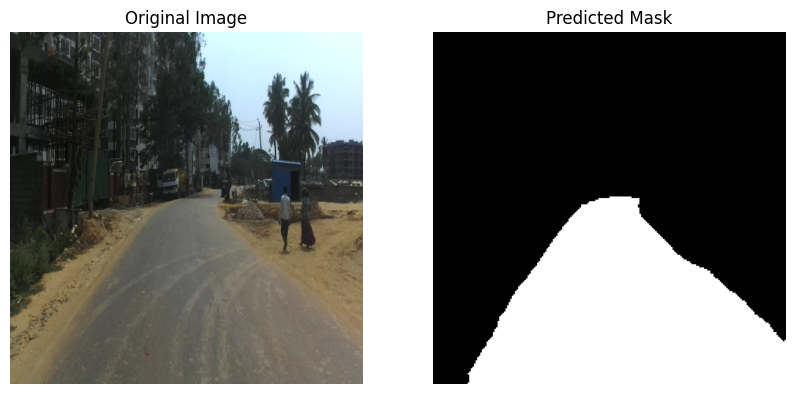

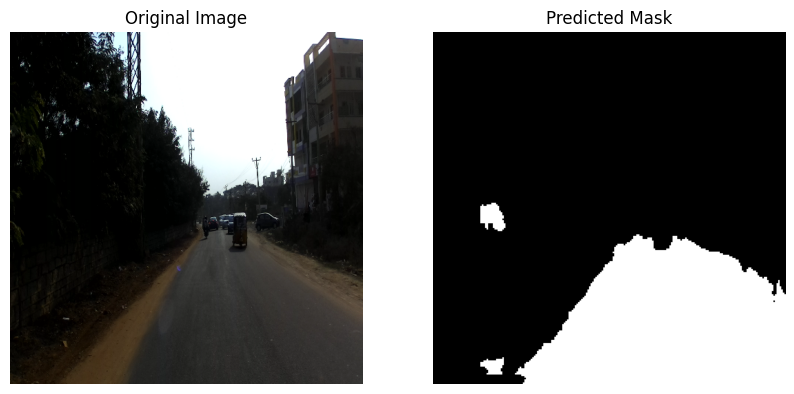

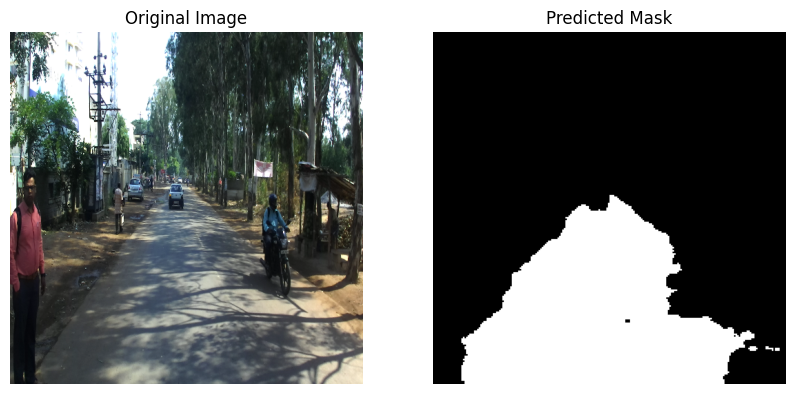

In [18]:

        
#add image paths here to test accordingly
sample_image_paths=['/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/13/030635_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/12/157320_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/179/134336_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/14/528816_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/111/000149_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/123/294914_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/169/139164_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/27/025403_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/4/599036_leftImg8bit.png']
    
predictions = test_model(vanilla_unet, sample_image_paths, device)
visualize_predictions(sample_image_paths, predictions)


In [19]:
pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# 2. DeepLabV3+ with Resnet Encoder

In [20]:
import segmentation_models_pytorch as smp

resnet_unet=smp.DeepLabV3Plus(encoder_name='resnet34',activation=None,encoder_weights='imagenet',classes=1)
resnet_unet.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_unet.parameters(), lr=learning_rate, weight_decay=decay)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [21]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    resnet_unet.train()
    train_loss = 0.0
    train_iou = 0.0
    train_dice = 0.0
    for images, masks in tqdm(train_dl):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()  
        outputs = resnet_unet(images)
        
        loss = criterion(outputs, masks.unsqueeze(1))  
        loss.backward()  
        optimizer.step()  
        
        train_loss += loss.item()
        train_iou += iou_metric(outputs, masks)
        train_dice += dice_score(outputs, masks)

    avg_train_loss = train_loss / len(train_dl)
    avg_train_iou = train_iou / len(train_dl)
    avg_train_dice = train_dice / len(train_dl)

    train_losses.append(avg_train_loss)

    resnet_unet.eval()  
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0
    
    with torch.no_grad():  
        for val_images, val_masks in val_dl:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            
            val_outputs = resnet_unet(val_images)
            
            val_loss_value = criterion(val_outputs, val_masks.unsqueeze(1).float())
            val_loss += val_loss_value.item()
            val_iou += iou_metric(val_outputs, val_masks)
            val_dice += dice_score(val_outputs, val_masks)

    avg_val_loss = val_loss / len(val_dl)
    avg_val_iou = val_iou / len(val_dl)
    avg_val_dice = val_dice / len(val_dl)

    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
      f"Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Train DICE: {avg_train_dice:.4f}, "
      f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val DICE: {avg_val_dice:.4f}")

100%|██████████| 219/219 [02:50<00:00,  1.28it/s]


Epoch [1/10], Train Loss: 0.1887, Train IoU: 0.7466, Train DICE: 0.8524, Val Loss: 0.1187, Val IoU: 0.8426, Val DICE: 0.9131


100%|██████████| 219/219 [02:49<00:00,  1.29it/s]


Epoch [2/10], Train Loss: 0.1455, Train IoU: 0.7990, Train DICE: 0.8879, Val Loss: 0.1632, Val IoU: 0.7931, Val DICE: 0.8817


100%|██████████| 219/219 [02:49<00:00,  1.29it/s]


Epoch [3/10], Train Loss: 0.1375, Train IoU: 0.8108, Train DICE: 0.8952, Val Loss: 0.1292, Val IoU: 0.8417, Val DICE: 0.9126


100%|██████████| 219/219 [02:48<00:00,  1.30it/s]


Epoch [4/10], Train Loss: 0.1328, Train IoU: 0.8175, Train DICE: 0.8993, Val Loss: 0.1316, Val IoU: 0.8331, Val DICE: 0.9068


100%|██████████| 219/219 [02:49<00:00,  1.29it/s]


Epoch [5/10], Train Loss: 0.1290, Train IoU: 0.8220, Train DICE: 0.9020, Val Loss: 0.1036, Val IoU: 0.8634, Val DICE: 0.9252


100%|██████████| 219/219 [02:48<00:00,  1.30it/s]


Epoch [6/10], Train Loss: 0.1265, Train IoU: 0.8251, Train DICE: 0.9039, Val Loss: 0.1143, Val IoU: 0.8505, Val DICE: 0.9176


100%|██████████| 219/219 [02:49<00:00,  1.29it/s]


Epoch [7/10], Train Loss: 0.1240, Train IoU: 0.8278, Train DICE: 0.9056, Val Loss: 0.1117, Val IoU: 0.8478, Val DICE: 0.9157


100%|██████████| 219/219 [02:50<00:00,  1.29it/s]


Epoch [8/10], Train Loss: 0.1194, Train IoU: 0.8345, Train DICE: 0.9096, Val Loss: 0.1313, Val IoU: 0.8049, Val DICE: 0.8887


100%|██████████| 219/219 [02:49<00:00,  1.29it/s]


Epoch [9/10], Train Loss: 0.1191, Train IoU: 0.8349, Train DICE: 0.9098, Val Loss: 0.1032, Val IoU: 0.8645, Val DICE: 0.9259


100%|██████████| 219/219 [02:48<00:00,  1.30it/s]


Epoch [10/10], Train Loss: 0.1216, Train IoU: 0.8302, Train DICE: 0.9069, Val Loss: 0.0963, Val IoU: 0.8740, Val DICE: 0.9315


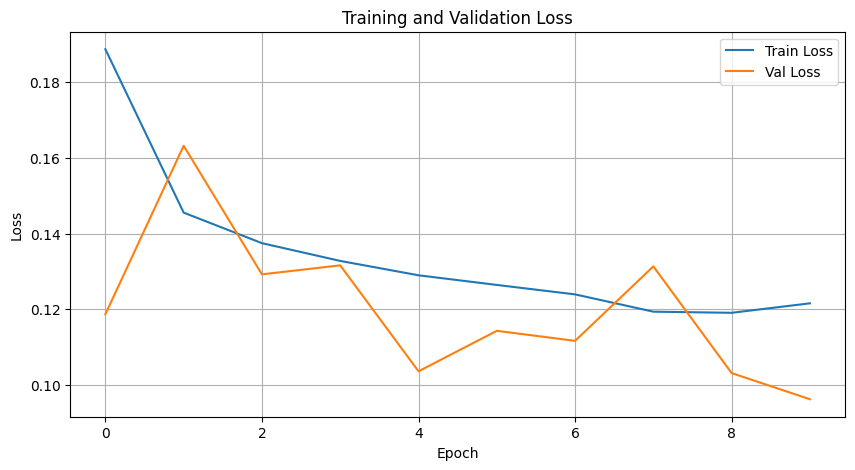

In [22]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

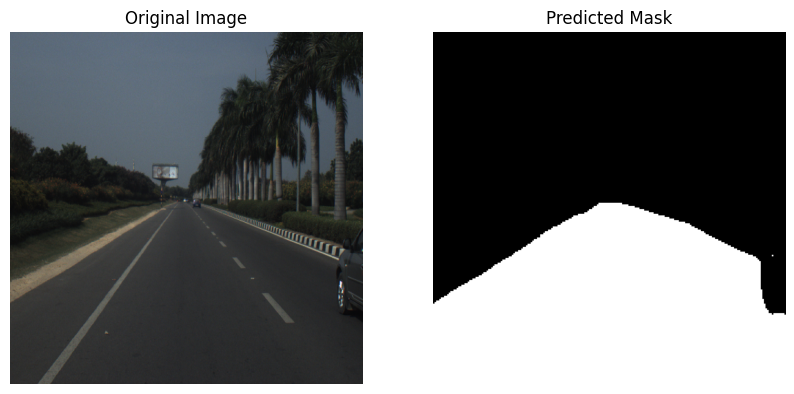

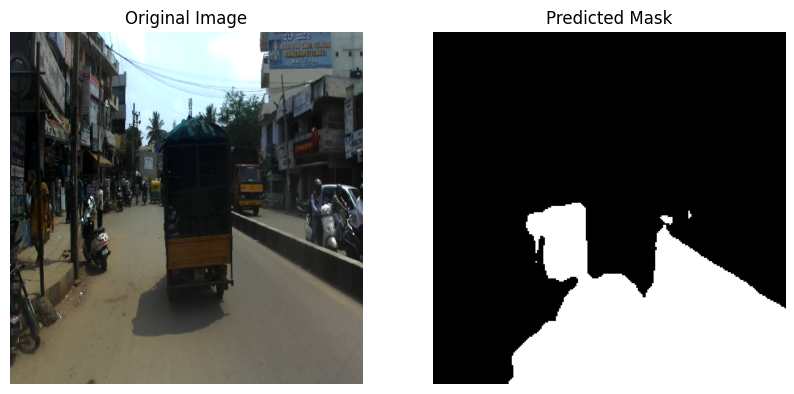

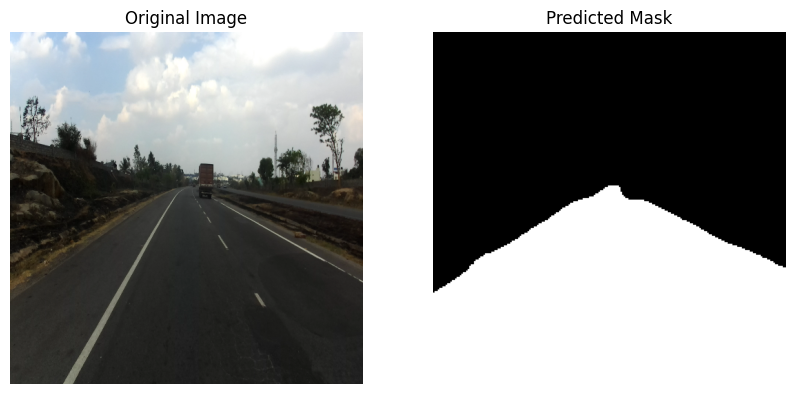

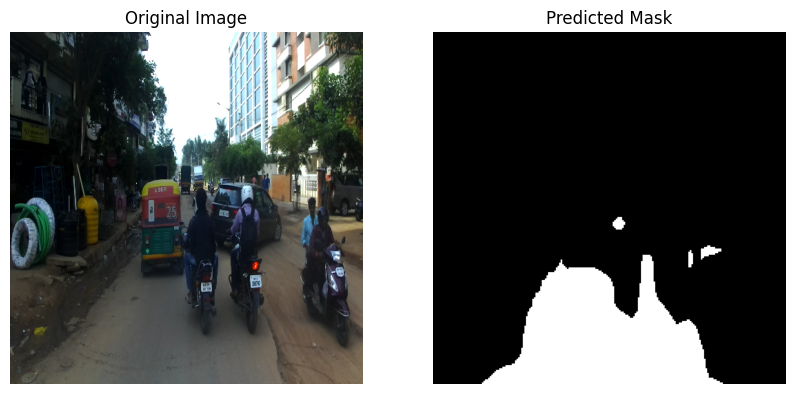

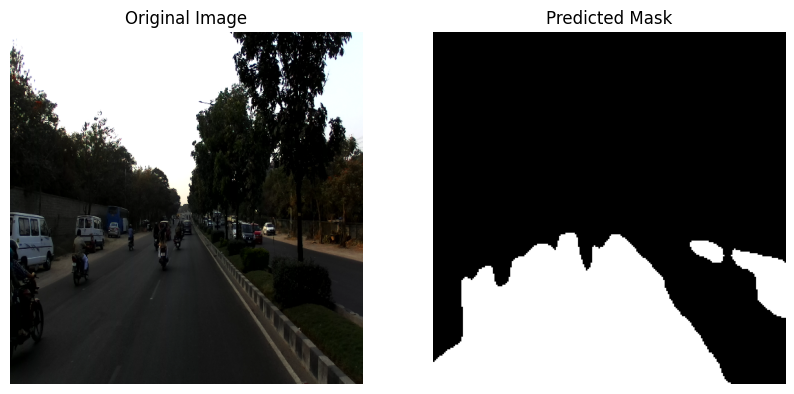

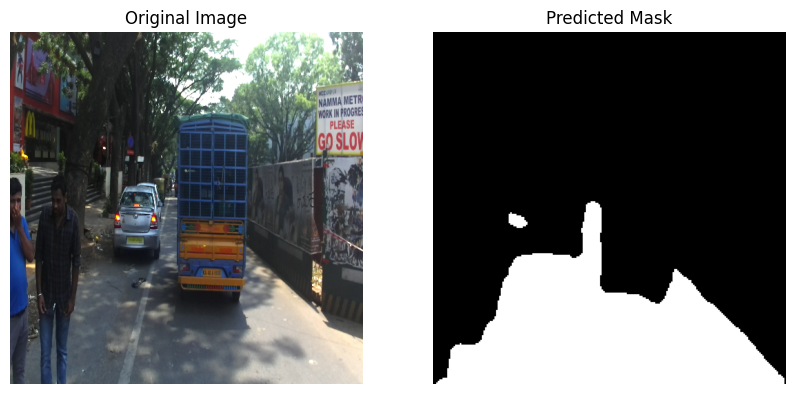

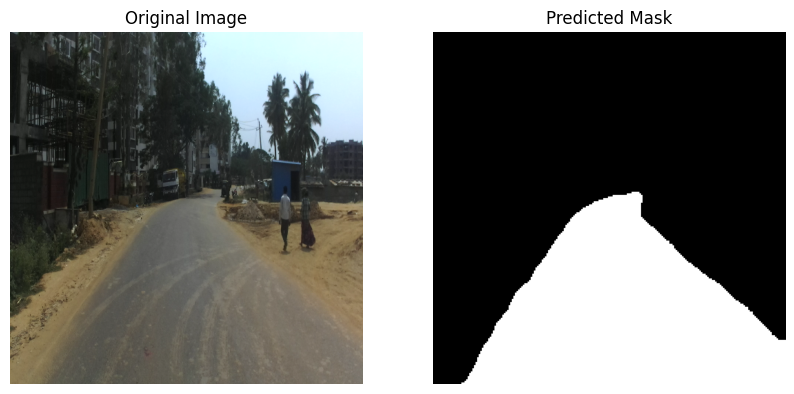

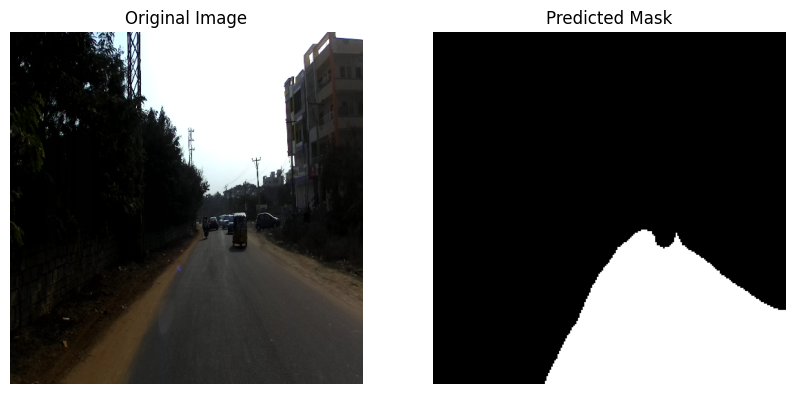

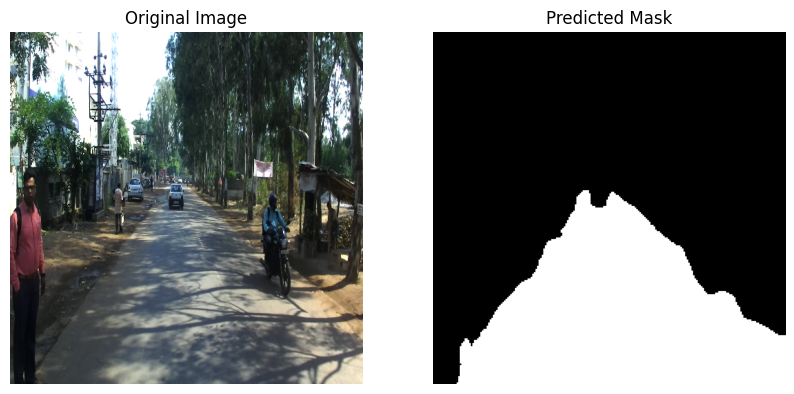

In [23]:
sample_image_paths=['/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/13/030635_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/12/157320_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/179/134336_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/14/528816_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/111/000149_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/123/294914_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/169/139164_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/27/025403_leftImg8bit.png',
                   '/kaggle/input/segmentation-dataset/IDD_Segmentation/leftImg8bit/test/4/599036_leftImg8bit.png']

predictions = test_model(resnet_unet, sample_image_paths, device)
visualize_predictions(sample_image_paths, predictions)